## Calculate the evaporation timeseries of the GLEAM model per catchment

In [51]:
import xarray as xr
import rioxarray as rio
import geopandas as gpd

from pathlib import Path
from glob import glob

## Set Paths

In [52]:
# Set Paths
ROOT = Path('/gpfs/work1/0/wtrcycle/users/jaerts/model_refinement_pub/')
AUXDIR = Path(f"{ROOT}/aux_data/")
OBSDIR = Path(f"{ROOT}/observations/")
OUTPUT = Path(f"{ROOT}/results/streamflow_evaluation/wflow_sbm_evaluation/")

## Load catchment shapefile

In [109]:
gdf = gpd.read_file(f'{AUXDIR}/camels-gb/CAMELS_GB_catchment_boundaries/CAMELS_GB_catchment_boundaries.shp',crs=27700)
gdf = gdf.to_crs(4326)

## Load GLEAM evaporation files and concatenate

In [110]:
files = glob(f'{OBSDIR}/evaporation/GLEAM/v3.6b/E_*_GLEAM_v3.6b.nc')
ds = xr.open_mfdataset(files)

## Clip GLEAM using catchment shapefiles

In [111]:
gdf = gdf[:3]

In [112]:
# ds = ds.rename_dims({'lon':'x','lat':'y'})
# Write CRS
espg='4326'
ds = ds.rio.write_crs(f"epsg:{espg}", inplace=True)
# ds = ds.rio.set_spatial_dims("lon", "lat", inplace=True)
ds = ds.rename({'lon':'x','lat':'y'})

In [113]:
ds.rio.clip([row.geometry], all_touched=True)

NoDataInBounds: No data found in bounds. Data variable: E

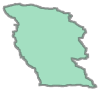

In [119]:
gdf.geometry[2]

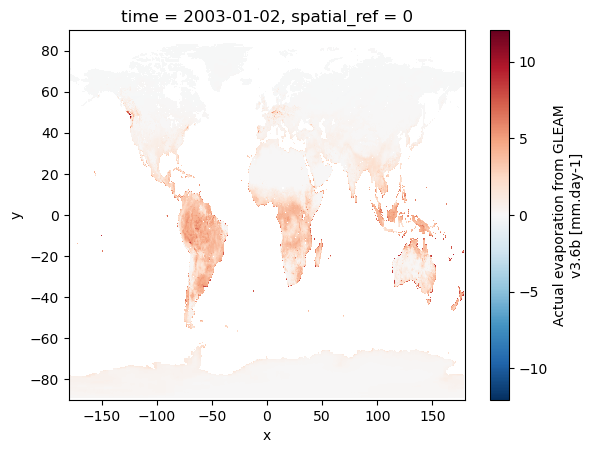

In [87]:
ds.E.isel(time=1).plot()

In [32]:
for index, row in gdf.iterrows():
    row.geometry

In [46]:
ds.rio.write_crs()

MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'.

In [ ]:
refinement/aux_data/camels-gb/CAMELS_GB_catchment_boundaries/CAMELS_GB_catchment_boundaries.shp

In [ ]:
Clip files using rioxarray :)

In [2]:
xr.open_dataset('~/refinement/observations/evaporation/GLEAM/v3.6b/E_2003_GLEAM_v3.6b.nc')

<xarray.Dataset>
Dimensions:  (time: 365, lon: 1440, lat: 720)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
Data variables:
    E        (time, lat, lon) float32 ...
Attributes:
    Dataset:      Global Land Evaporation Amsterdam Model
    Version:      3.6b
    Authors:      Hydro-Climate Extremes Lab (H-CEL)
    Institution:  Ghent University
    Contact:      info@gleam.eu
    Reference1:   Martens, B. et al. 2017: GLEAM v3: satellite-based land eva...
    Reference2:   Miralles, D.G. et al. 2011: Global land-surface evaporation...

In [100]:
import odc.stac
import planetary_computer
import pystac_client
import rich.table

In [101]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [127]:
bbox = [gdf.bounds.minx[0], gdf.bounds.miny[0], gdf.bounds.maxx[0], gdf.bounds.maxy[0]]

In [129]:
year='2015'

In [143]:
months = {
    "January": "01",
}

In [144]:
items = dict()

In [169]:
for name, number in months.items():
    datetime = f"{year}-{number}"
    search = catalog.search(
        collections=["modis-16A2-061"],
        bbox=bbox,
        datetime=datetime,
    )
    items[name] = search.get_all_items()[0]

print(items)

IndexError: list index out of range

In [189]:
search = catalog.search(
    collections=["modis-16A3GF-061"],
    bbox=bbox,
    datetime='2020-05',
)
items[name] = search.get_all_items()[0]

print(items)

{'January': <Item id=MYD16A3GF.A2020001.h17v03.061.2021025022046>}


In [173]:
item = items["January"]

t = rich.table.Table("Key", "Title")
for key, asset in items["January"].assets.items():
    t.add_row(key, asset.title)


┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Title                                             ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hdf              │ Source data containing all bands                  │
│ ET_500m          │ Total of Evapotranspiration                       │
│ LE_500m          │ Average of Latent Heat Flux                       │
│ PET_500m         │ Total Potential Evapotranspiration                │
│ PLE_500m         │ Average of Potential Latent Heat Flux             │
│ metadata         │ Federal Geographic Data Committee (FGDC) Metadata │
│ ET_QC_500m       │ Evapotranspiration Quality Assessment             │
│ tilejson         │ TileJSON with default rendering                   │
│ rendered_preview │ Rendered preview                                  │
└──────────────────┴───────────────────────────────────────────────────┘

In [193]:
data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bands="ET_500m",
    resolution=500,
    bbox=bbox,
)

raster = items["January"].assets["ET_500m"].extra_fields["raster:bands"]
data = data["ET_500m"] * raster[0]["scale"]
data = data * 0.1

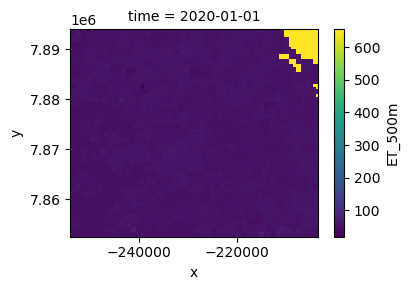

In [194]:
data.plot.imshow(cmap="viridis", col="time");

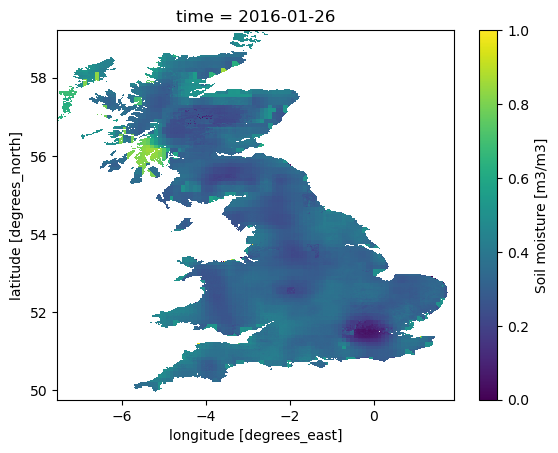

In [203]:
xr.open_dataset("/gpfs/work1/0/wtrcycle/users/jaerts/model_refinement_pub/observations/soil_moisture/HydroJULES_soil_moisture/merge_1km_tc_ref_smap.nc").sm.isel(time=300).plot()